# Understanding the Fourier Transform by example
How to implement the Fast Fourier Transform algorithm in Python from scratch. <br />
@author: Simon J. Buehrer <br />
@date: 2021-02-04 <br /><br />
**Links:**
<ul>
<li> https://towardsdatascience.com/fast-fourier-transform-937926e591cb </li>
<li> https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/ </li>
<li> https://towardsdatascience.com/analyzing-seasonality-with-fourier-transforms-using-python-scipy-bb46945a23d3 </li>
</ul> 

In [205]:
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
import datetime as dt 

import yfinance as yf #pip install yfinance /or pip3 /or conda
import numpy as np
import statsmodels.api as sm
from scipy.signal import find_peaks

# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 

import math



## get data

In [206]:
#get current day and download hist. data 
today = dt.datetime.today().strftime('%Y-%m-%d')
hist = (dt.datetime.today()-dt.timedelta(5000)).strftime('%Y-%m-%d')

stockname='ABB'
print(today,hist)
stockdata_df = yf.download(stockname, start=hist, end=today)
print(stockdata_df.tail(5))

2021-02-07 2007-06-01
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2021-02-01  29.790001  30.160000  29.660000  30.139999  30.139999  1500400
2021-02-02  30.160000  30.520000  30.120001  30.469999  30.469999  1678900
2021-02-03  30.459999  30.639999  30.389999  30.559999  30.559999  1778900
2021-02-04  29.110001  29.129999  28.760000  29.020000  29.020000  4598100
2021-02-05  28.900000  28.990000  28.700001  28.820000  28.820000  1711400


## Calculating the difference (OLS)
und e neui column dezue tue wel datum müesam isch

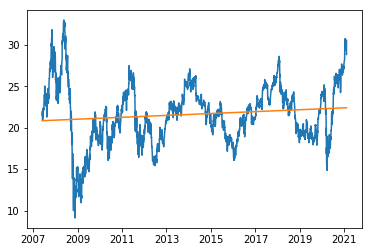

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     54.17
Date:                Sun, 07 Feb 2021   Prob (F-statistic):           2.29e-13
Time:                        14:49:15   Log-Likelihood:                -9303.8
No. Observations:                3447   AIC:                         1.861e+04
Df Residuals:                    3445   BIC:                         1.862e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.8388      0.123    170.047      0.0

In [207]:
stockdata_df['row_num'] = np.arange(len(stockdata_df))
X = sm.add_constant(stockdata_df['row_num']) 
model = sm.OLS(stockdata_df['Close'], X).fit()
stockdata_df['OLS'] = model.predict(X) 

plt.plot(stockdata_df.index,stockdata_df['Close']) 
plt.plot(stockdata_df.index,stockdata_df['OLS'])
plt.show() 
print(model.summary())

stockdata_df['Diff']=stockdata_df['Close']-stockdata_df['OLS']

## es paar Diagramm
Afoch welis chan

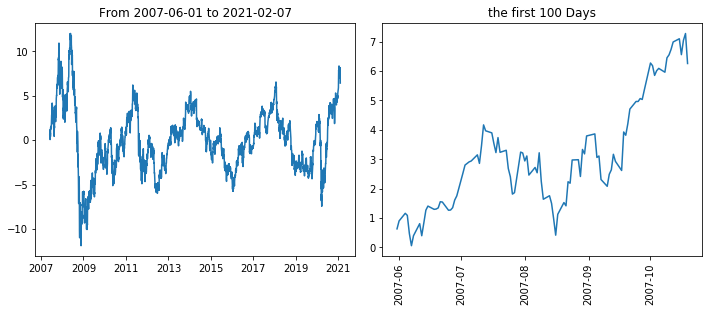

In [208]:
plt.figure(figsize=(10, 4))

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(stockdata_df.index,stockdata_df['Diff']) 
ax1.set_title("From " + hist + " to " +today)

N=100
ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(stockdata_df.index[:N],stockdata_df['Diff'][:N]) 
ax2.set_title("the first " + str(N) +" Days")

plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

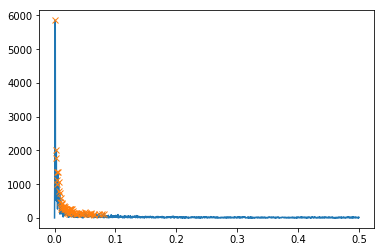

59


In [209]:
fft_output = np.fft.fft(stockdata_df['Diff'])
power = np.abs(fft_output)
freq = np.fft.fftfreq(len(stockdata_df['Diff']))

# mask susch au negativi drinää
mask = freq >= 0
freq = freq[mask]
power = power[mask]

peaks, _ = find_peaks(power[freq >=0], height=100)

plt.plot(freq,power)
plt.plot(freq[peaks], power[peaks],'x')
plt.show() 
print(len(peaks))


In [210]:
output = pd.DataFrame()
output['index'] = peaks
output['freq'] = freq[peaks]
output['amplitude'] = power[peaks]
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

output.head()

,index,freq,amplitude,fft
0,4,0.001160,5858.187740,5562.613394-1837.306677j
2,10,0.002901,2008.097679,396.560669+1968.551732j
1,8,0.002321,1771.674061,-1668.651444-595.341362j
3,12,0.003481,1366.687421,1279.791370+479.550367j
6,19,0.005512,1354.534472,-1285.849903+425.856386j


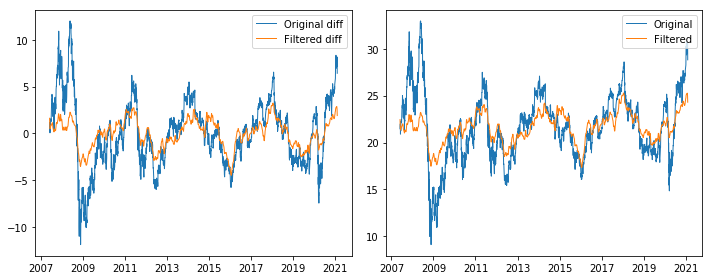

In [211]:
filtered_fft_output = np.array([f if i in list(output['index']) else 0 for i, f in enumerate(fft_output)])
filtered_diff = np.fft.ifft(filtered_fft_output)

stockdata_df['Filtered']=stockdata_df['OLS']+filtered_diff

plt.figure(figsize=(10, 4))
ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(stockdata_df.index, stockdata_df['Diff'], linewidth=1, label='Original diff')
ax1.plot(stockdata_df.index, filtered_diff.real, linewidth=1, label='Filtered diff')
ax1.legend(loc='upper right')

ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(stockdata_df.index, stockdata_df['Close'], linewidth=1, label='Original')
ax2.plot(stockdata_df.index, stockdata_df['Filtered'], linewidth=1, label='Filtered')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


## Incorporating into our regression

The problem with these sinusoids is that the amplitude is off!

In [212]:
from cmath import phase

fourier_terms = pd.DataFrame()
fourier_terms['fft'] = output['fft']
fourier_terms['freq'] = output['freq']
fourier_terms['amplitude'] = fourier_terms.fft.apply(lambda z: abs(z)) 
fourier_terms['phase'] = fourier_terms.fft.apply(lambda z: phase(z))
fourier_terms.sort_values(by=['amplitude'], ascending=[0])

# Create some helpful labels (FT_1..FT_N)
fourier_terms['label'] = list(map(lambda n : 'FT_{}'.format(n), range(1, len(fourier_terms) + 1)))

# Turn our dataframe into a dictionary for easy lookup
fourier_terms = fourier_terms.set_index('label')
fourier_terms_dict = fourier_terms.to_dict('index')

fourier_terms.head()

,fft,freq,amplitude,phase
label,,,,
FT_1,5562.613394-1837.306677j,0.001160,5858.187740,-0.319014
FT_2,396.560669+1968.551732j,0.002901,2008.097679,1.372009
FT_3,-1668.651444-595.341362j,0.002321,1771.674061,-2.798891
FT_4,1279.791370+479.550367j,0.003481,1366.687421,0.358516
FT_5,-1285.849903+425.856386j,0.005512,1354.534472,2.821775


In [213]:
for key in fourier_terms_dict.keys():
    a = fourier_terms_dict[key]['amplitude']
    w = 2 * math.pi * (fourier_terms_dict[key]['freq'])
    p = fourier_terms_dict[key]['phase']
    stockdata_df[key] = stockdata_df['row_num'].apply(lambda t: a * math.cos(w*t + p))

stockdata_df['FT_All'] = 0
for column in list(fourier_terms.index):
    stockdata_df['FT_All'] = stockdata_df['FT_All'] + stockdata_df[column]


# Sample 
stockdata_df[['Close', 'row_num', 'FT_All']  + list(fourier_terms.index)].head()

,Close,row_num,FT_All,FT_1,FT_2,FT_3,FT_4,FT_5,FT_6,FT_7,...,FT_50,FT_51,FT_52,FT_53,FT_54,FT_55,FT_56,FT_57,FT_58,FT_59
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-31,21.469999,0,5560.347590,5562.613394,396.560669,-1668.651444,1279.791370,-1285.849903,-1094.635915,686.597608,...,117.345729,39.287590,85.050911,-50.510016,-73.611759,25.577384,-61.799236,-105.067926,69.730712,-23.755072
2007-06-01,21.740000,1,4568.533651,5575.861575,360.614052,-1659.792842,1268.996576,-1299.824627,-1100.428680,652.593003,...,106.554618,-6.277084,31.266816,-65.271468,-98.249037,-18.874781,-87.769412,-96.738420,40.462595,16.240954
2007-06-04,22.000000,2,3652.705197,5588.813336,324.547622,-1650.581297,1257.594650,-1312.240423,-1105.285506,617.441534,...,90.601021,-50.950193,-30.598469,-78.541747,-109.716004,-60.223722,-102.988529,-65.279452,6.829873,53.636866
2007-06-05,21.930000,3,2874.672872,5601.467988,288.373360,-1641.018770,1245.591048,-1323.082402,-1109.202259,581.204977,...,70.257877,-88.386595,-84.555304,-90.017684,-106.475510,-91.671212,-105.592367,-18.212635,-27.539572,82.445726
2007-06-06,21.309999,4,2278.568860,5613.824859,252.103286,-1631.107292,1232.991513,-1332.337560,-1112.175610,543.947014,...,46.510794,-113.269013,-116.658065,-99.437102,-88.961943,-108.046936,-95.261977,33.208693,-58.938387,98.055349


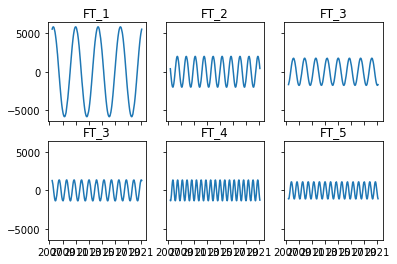

In [214]:

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
for i in range(0,2):
    for j in range(0,3):
        ax[i][j].set_title('FT_'+str(j+1+i*2))
        ax[i][j].plot(stockdata_df.index, stockdata_df['FT_'+str(j+1+i*3)])



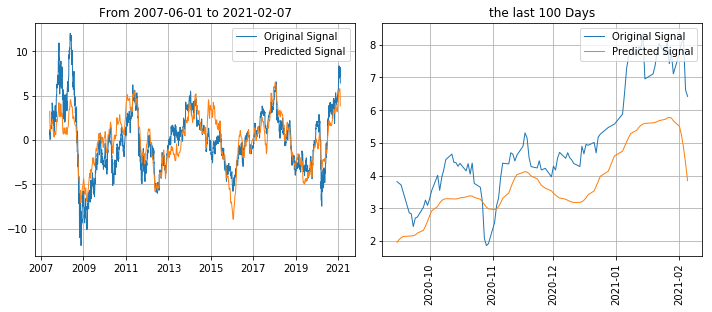

                                 OLS Regression Results                                
Dep. Variable:                   Diff   R-squared (uncentered):                   0.682
Model:                            OLS   Adj. R-squared (uncentered):              0.682
Method:                 Least Squares   F-statistic:                              3695.
Date:                Sun, 07 Feb 2021   Prob (F-statistic):                        0.00
Time:                        14:49:17   Log-Likelihood:                         -7328.9
No. Observations:                3447   AIC:                                  1.466e+04
Df Residuals:                    3445   BIC:                                  1.467e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [215]:
X = pd.DataFrame(stockdata_df[['row_num','FT_All']]) 
y = pd.DataFrame(stockdata_df['Diff'])

model = sm.OLS(y, X).fit()
y_predict = model.predict(X) 


plt.figure(figsize=(10, 4))

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(stockdata_df.index, stockdata_df['Diff'], linewidth=1, label='Original Signal')
ax1.plot(stockdata_df.index, y_predict, linewidth=1, label='Predicted Signal')
ax1.legend(loc='upper right')
ax1.grid()
ax1.set_title("From " + hist + " to " +today)


N=100
ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(stockdata_df.index[-N:], stockdata_df['Diff'][-N:], linewidth=1, label='Original Signal')
ax2.plot(stockdata_df.index[-N:], y_predict[-N:], linewidth=1, label='Predicted Signal')
ax2.legend(loc='upper right')
ax2.grid()
ax2.set_title("the last " + str(N) +" Days")

plt.tight_layout()
plt.xticks(rotation=90)
plt.show()


print(model.summary())